In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import dynamiqs as dq
import numpy as np
from tqdm import tqdm
from copy import deepcopy
from tqdm.notebook import tqdm

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("optimised for nvidia graphics card")
elif torch.backends.mps.is_available():
    device =torch.device("mps")
    print("optimised for mac ARM architecture")
else:
    device = torch.device("cpu")

optimised for mac ARM architecture


In [9]:
def add_random_noise(wigner_set,K):
    return [el + K*np.random.standard_normal(size = el.shape) for el in wigner_set]
        


# Example: Simulate coherent and squeezed states
N = 30
beta = 1.5
K = 0.4
states = []

# Generate a list of quantum states (coherent, squeezed, etc.)
for beta in tqdm(np.linspace(-4, 4, 200)):
    for phase in np.linspace(0,np.pi*1.9,10):
        beta_c = beta*np.exp(1j*phase)

        cat_state_plus = dq.unit(dq.coherent(N, beta_c) + dq.coherent(N, -beta_c))
        states.append(cat_state_plus)
        cat_state_minus = dq.unit(dq.coherent(N, beta_c) - dq.coherent(N, -beta_c))
        states.append(cat_state_minus)
  
# Wigner function of each state
true_set_np = np.array([dq.wigner(state)[-1] for state in states])
data_set_np = np.array(add_random_noise(true_set_np, K ))

data_set = torch.tensor(data_set_np, dtype=torch.float32).unsqueeze(1)  # shape becomes [100, 1, 201, 201]
true_set = torch.tensor(true_set_np, dtype=torch.float32).unsqueeze(1)

  0%|          | 0/200 [00:00<?, ?it/s]

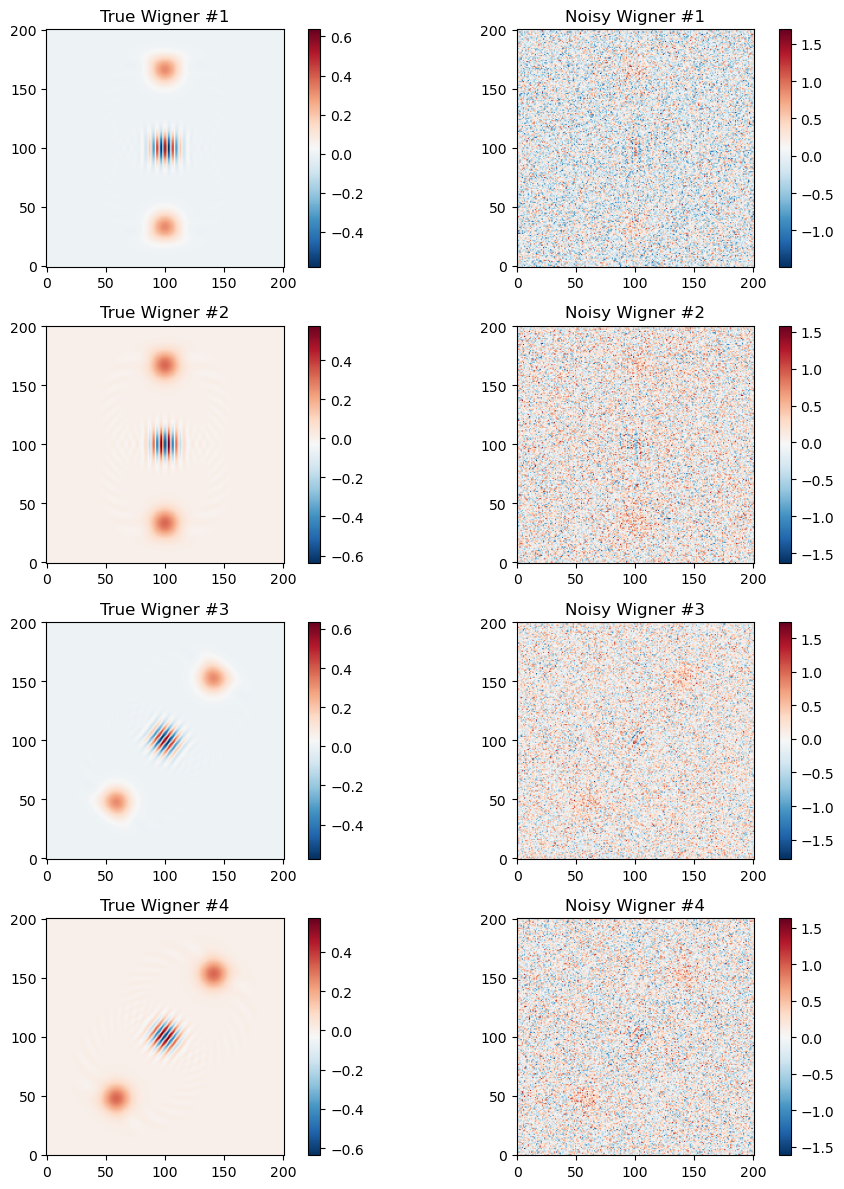

In [10]:
# Plotting
fig, axes = plt.subplots(4, 2, figsize=(10, 12))
for i in range(4):
    im0 = axes[i, 0].imshow(true_set_np[i], cmap="RdBu_r", origin="lower")
    axes[i, 0].set_title(f"True Wigner #{i+1}")
    plt.colorbar(im0, ax=axes[i, 0])
    
    im1 = axes[i, 1].imshow(data_set_np[i], cmap="RdBu_r", origin="lower")
    axes[i, 1].set_title(f"Noisy Wigner #{i+1}")
    plt.colorbar(im1, ax=axes[i, 1])

plt.tight_layout()
plt.show()

In [11]:
class Model_Convolutional_Autoencoder_With_Skips(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoding layers
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1),
                nn.ReLU()
            )

        self.encoder1 = conv_block(1, 8)       # (B, 1, H, W) → (B, 8, H, W)
        self.pool1 = nn.MaxPool2d(2, 2)        # (B, 8, H, W) → (B, 8, H/2, W/2)

        self.encoder2 = conv_block(8, 16)      # (B, 8, H/2, W/2) → (B, 16, H/2, W/2)
        self.pool2 = nn.MaxPool2d(2, 2)        # (B, 16, H/2, W/2) → (B, 16, H/4, W/4)

        # Decoding layers
        def deconv_block(in_ch, out_ch, stride=2):
            return nn.Sequential(
                nn.ConvTranspose2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, output_padding=1 if stride > 1 else 0),
                nn.ReLU()
            )

        self.upconv1 = deconv_block(16, 8)     # (B, 16, H/4, W/4) → (B, 8, H/2, W/2)
        self.upconv2 = deconv_block(16, 8, stride=1)  # after skip connection

        self.final = nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1)  # (B, 8, H/2, W/2) → (B, 1, H, W)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        l1 = self.encoder1(x)
        l1_pooled = self.pool1(l1)

        l2 = self.encoder2(l1_pooled)
        encoded = self.pool2(l2)

        d1 = self.upconv1(encoded)

        # Skip connection from encoder1
        d1_cat = torch.cat([d1, l1_pooled], dim=1)

        d2 = self.upconv2(d1_cat)
        out = self.final(d2)

        return out  # [-1, 1] range

In [ ]:
def train_model(train_dataset, validation_dataset, batch_size=64, learning_rate=1e-3, n_epochs=10, nb_repetition_max_no_improve=25):
    model = Model_Convolutional_Autoencoder_With_Skips()
    model.train()
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
    best_validation_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(n_epochs):
        model.train()
        current_epoch_train_loss = 0.0
        num_train_batches = 0
        for x, y in tqdm(data_loader, desc=f"Training Epoch {epoch}", leave=False):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            
            # Crop target y to match model output dimensions (200x200)
            output_h, output_w = output.shape[2], output.shape[3]
            y_target = y[:, :, :output_h, :output_w]
            
            # Calculate loss on the full (cropped) image
            loss = criterion(output, y_target) 
            
            loss.backward()
            optimizer.step()
            current_epoch_train_loss += loss.item()
            num_train_batches += 1
        avg_epoch_train_loss = current_epoch_train_loss / num_train_batches
        
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for x, y in validation_loader:
                x, y = x.to(device), y.to(device)
                output = model(x)
                
                # Crop target y to match model output dimensions
                output_h, output_w = output.shape[2], output.shape[3]
                y_target_val = y[:, :, :output_h, :output_w]
                
                # Calculate validation loss on the full (cropped) image
                batch_val_loss = criterion(output, y_target_val)
                val_loss += batch_val_loss.item() * x.size(0) # Accumulate sum of losses
            val_loss = val_loss / len(validation_dataset) # Average loss per sample
        
        # print(f"Epoch {epoch+1}/{n_epochs} training loss: {avg_epoch_train_loss:.6e}  validation loss: {val_loss:.6e}")
        
        if val_loss > best_validation_loss: # Check if current val_loss is worse than best
            epochs_no_improve += 1
            print(f"epochs with no improvement: {epochs_no_improve}")
            if epochs_no_improve >= nb_repetition_max_no_improve:
                print("No improvement. Stopping the training.")
                if best_model_state is None: # Handle case where no improvement happened at all
                    best_model_state = deepcopy(model.state_dict())
                break
        else:
            best_validation_loss = val_loss
            best_model_state = deepcopy(model.state_dict())
            epochs_no_improve = 0

    final_model = Model_Convolutional_Autoencoder_With_Skips()
    if best_model_state is not None:
        final_model.load_state_dict(best_model_state)
    else: # Fallback if training stops immediately or no best state saved
        final_model.load_state_dict(model.state_dict())
    final_model.to(device)
    return final_model

validation_split = 0.1
dataset_size = len(data_set)
val_size = int(dataset_size * validation_split)
train_size = dataset_size - val_size

generator = torch.Generator().manual_seed(0)
train_dataset, val_dataset = random_split(
    TensorDataset(data_set, true_set),
    [train_size, val_size],
    generator=generator
)
model = train_model(train_dataset, val_dataset ,n_epochs = 100,learning_rate=5e-3,batch_size=64,nb_repetition_max_no_improve = 5)

Training Epoch 0:   0%|          | 0/57 [00:00<?, ?it/s]

Training Epoch 1:   0%|          | 0/57 [00:00<?, ?it/s]

Training Epoch 2:   0%|          | 0/57 [00:00<?, ?it/s]

Training Epoch 3:   0%|          | 0/57 [00:00<?, ?it/s]

Training Epoch 4:   0%|          | 0/57 [00:00<?, ?it/s]

Training Epoch 5:   0%|          | 0/57 [00:00<?, ?it/s]

Training Epoch 6:   0%|          | 0/57 [00:00<?, ?it/s]

Training Epoch 7:   0%|          | 0/57 [00:00<?, ?it/s]

Training Epoch 8:   0%|          | 0/57 [00:00<?, ?it/s]

Training Epoch 9:   0%|          | 0/57 [00:00<?, ?it/s]

Training Epoch 10:   0%|          | 0/57 [00:00<?, ?it/s]

Training Epoch 11:   0%|          | 0/57 [00:00<?, ?it/s]

Training Epoch 12:   0%|          | 0/57 [00:00<?, ?it/s]

Training Epoch 13:   0%|          | 0/57 [00:00<?, ?it/s]

Training Epoch 14:   0%|          | 0/57 [00:00<?, ?it/s]

Training Epoch 15:   0%|          | 0/57 [00:00<?, ?it/s]

Training Epoch 16:   0%|          | 0/57 [00:00<?, ?it/s]

Training Epoch 17:   0%|          | 0/57 [00:00<?, ?it/s]

Training Epoch 18:   0%|          | 0/57 [00:00<?, ?it/s]

Training Epoch 19:   0%|          | 0/57 [00:00<?, ?it/s]

Training Epoch 20:   0%|          | 0/57 [00:00<?, ?it/s]

Training Epoch 21:   0%|          | 0/57 [00:00<?, ?it/s]

Training Epoch 22:   0%|          | 0/57 [00:00<?, ?it/s]

Training Epoch 23:   0%|          | 0/57 [00:00<?, ?it/s]

Training Epoch 24:   0%|          | 0/57 [00:00<?, ?it/s]

Training Epoch 25:   0%|          | 0/57 [00:00<?, ?it/s]

Predicting val output: 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]


Validation MSE on full 200x200 region: 3.661488e-04


/var/folders/fk/hmv53d5d1_3cgsz0l5mhkjph0000gn/T/ipykernel_26154/3414175535.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


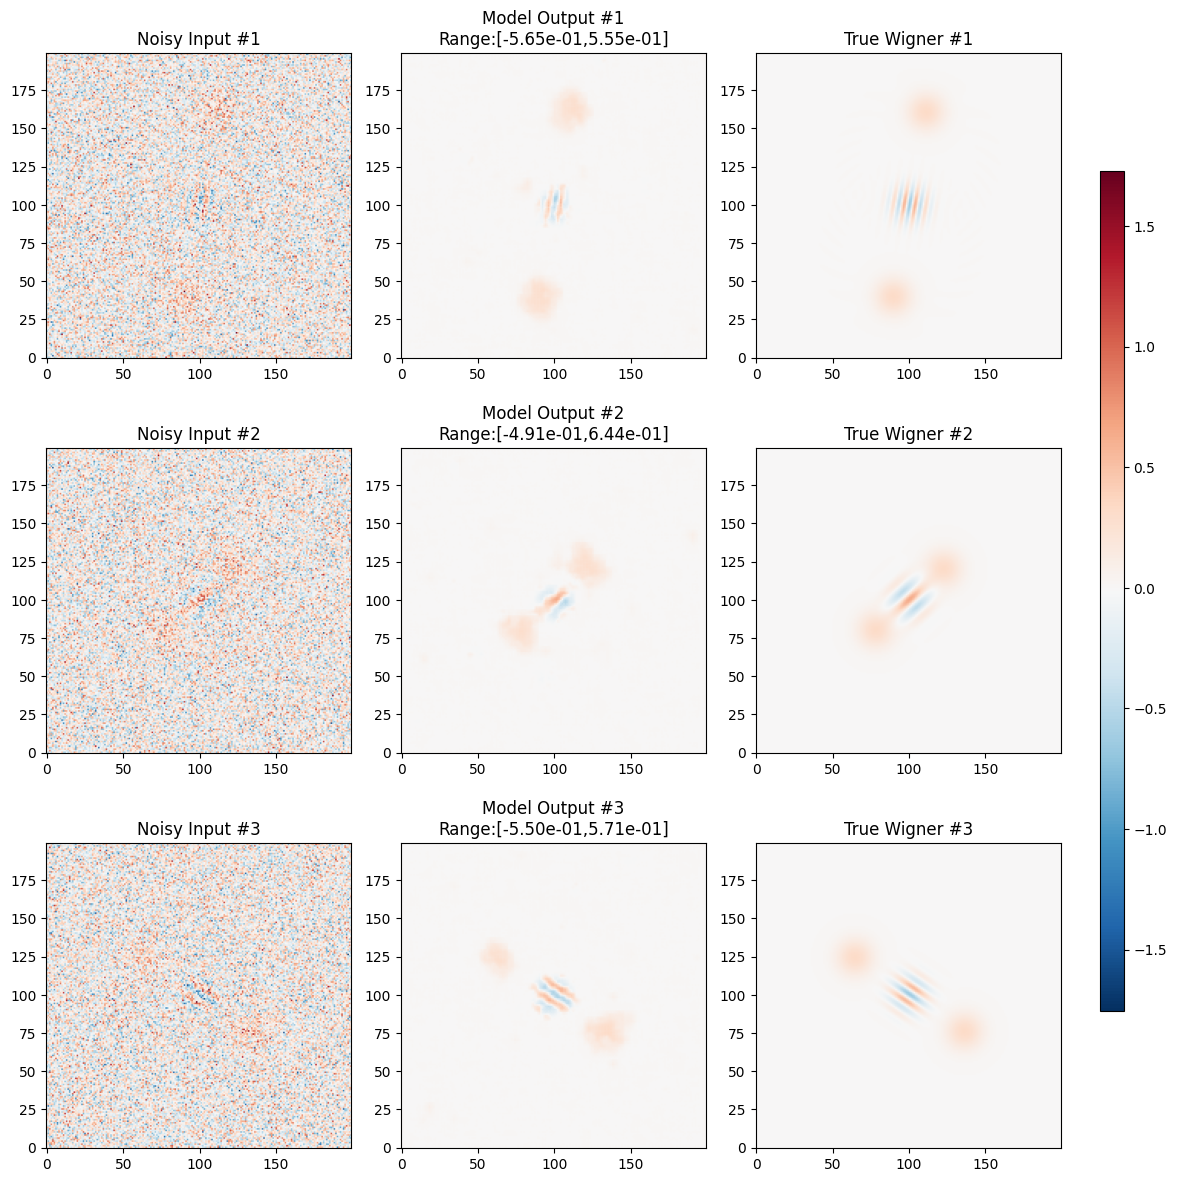

In [ ]:
def test_model_on_val(model, val_dataset, batch_size=64):
    model.eval()
    model.to(device)

    # val_dataset already gives (input, target) pairs.
    # We need to extract all inputs and all targets separately if processing in one go.
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Use DataLoader for batching

    val_outputs_list = []
    val_targets_list = []
    val_inputs_list = []

    with torch.no_grad():
        for inputs_batch, targets_batch in tqdm(val_loader, desc="Predicting val output"):
            inputs_batch = inputs_batch.to(device)
            # targets_batch doesn't need to go to device yet if only for final CPU comparison

            batch_out = model(inputs_batch)
            val_outputs_list.append(batch_out.cpu())
            
            # Crop targets to match model output size (200x200)
            output_h, output_w = batch_out.shape[2], batch_out.shape[3]
            targets_batch_cropped = targets_batch[:, :, :output_h, :output_w]
            val_targets_list.append(targets_batch_cropped)
            
            # Optionally store inputs if needed later (already cropped if necessary)
            inputs_batch_cropped = inputs_batch[:, :, :output_h, :output_w] # Crop inputs for consistent comparison shape
            val_inputs_list.append(inputs_batch_cropped.cpu())


    val_outputs = torch.cat(val_outputs_list)
    val_targets_cropped = torch.cat(val_targets_list) # These are already cropped
    val_inputs_cropped = torch.cat(val_inputs_list)   # These are also cropped

    assert val_outputs.shape == val_targets_cropped.shape, (
        f"Expected output shape {val_targets_cropped.shape}, but got {val_outputs.shape}."
    )
    assert val_outputs.shape == val_inputs_cropped.shape, (
        f"Expected output shape {val_inputs_cropped.shape}, but got {val_outputs.shape}."
    )

    # Convert and clip predicted output
    val_outputs_np = val_outputs.numpy()
    save_data_clipped = np.clip(val_outputs_np, -1, 1) # Assuming output is already in [-1,1]
                                                        # If you scale to 0-255 for uint8:
                                                        # save_data_clipped = np.clip((val_outputs_np * 0.5 + 0.5) * 255, 0, 255)
                                                        # save_data_uint8 = save_data_clipped.astype(np.uint8)
                                                        # For Wigner functions, direct float saving is often better
    
    # Save the full reconstructed image (as float32 numpy array)
    np.savez_compressed("submit_this_val_data_output_full.npz", data=val_outputs_np)

    # Compute MSE on the full 200x200 region
    # val_targets_cropped is already on CPU and cropped
    mse = torch.nn.functional.mse_loss(val_outputs, val_targets_cropped)
    print(f"Validation MSE on full 200x200 region: {mse.item():.6e}")

    # --- For plotting example (using the first few from the concatenated tensors) ---
    example_inputs = val_inputs_cropped[:3]
    example_outputs_plot = val_outputs[:3]
    example_targets_plot = val_targets_cropped[:3]

    all_data = torch.cat([example_inputs, example_outputs_plot, example_targets_plot])
    vmin = all_data.min().item()
    vmax = all_data.max().item()

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    for i in range(3):
        im0 = axes[i, 0].imshow(example_inputs[i].squeeze().numpy(), cmap="RdBu_r", origin="lower", vmin=vmin, vmax=vmax)
        axes[i, 0].set_title(f"Noisy Input #{i+1}")

        out_img = example_outputs_plot[i].squeeze().numpy()
        im1 = axes[i, 1].imshow(out_img, cmap="RdBu_r", origin="lower", vmin=vmin, vmax=vmax)
        axes[i, 1].set_title(f"Model Output #{i+1}\nRange:[{out_img.min():.2e},{out_img.max():.2e}]") # Show output range

        im2 = axes[i, 2].imshow(example_targets_plot[i].squeeze().numpy(), cmap="RdBu_r", origin="lower", vmin=vmin, vmax=vmax)
        axes[i, 2].set_title(f"True Wigner #{i+1}")

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    plt.colorbar(im2, cax=cbar_ax)
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

test_model_on_val(model, val_dataset, batch_size=64)



/var/folders/fk/hmv53d5d1_3cgsz0l5mhkjph0000gn/T/ipykernel_26154/1327577052.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar


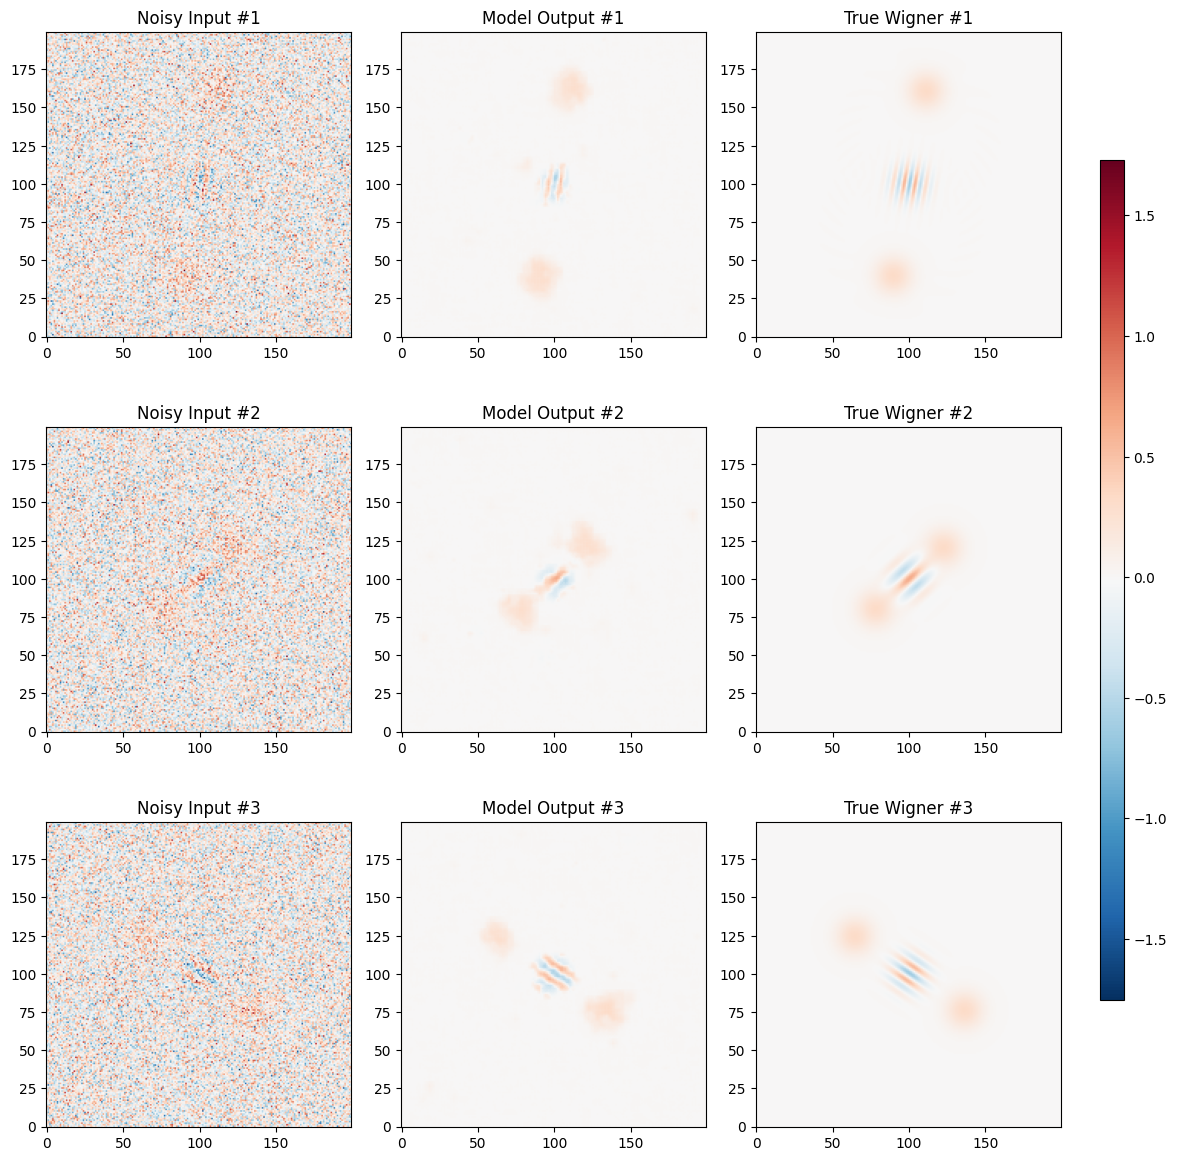

In [ ]:
# Pick 3 samples from the validation set
example_inputs = val_dataset[:][0][:3]  # shape: (3, 1, H, W)
example_targets = val_dataset[:][1][:3]

# Move model to device and eval mode
model.eval()
model.to(device)

# Run prediction
with torch.no_grad():
    example_inputs_device = example_inputs.to(device)
    example_outputs = model(example_inputs_device).cpu()

# Adjust shape if needed
if example_outputs.shape[-1] != example_inputs.shape[-1]:
    example_inputs = example_inputs[:, :, :example_outputs.shape[2], :example_outputs.shape[3]]
    example_targets = example_targets[:, :, :example_outputs.shape[2], :example_outputs.shape[3]]

# Determine common vmin and vmax for colorbar
all_data = torch.cat([example_inputs, example_outputs, example_targets])
vmin = all_data.min().item()
vmax = all_data.max().item()

# Plotting
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    im0 = axes[i, 0].imshow(example_inputs[i].squeeze().numpy(), cmap="RdBu_r", origin="lower",
                            vmin=vmin, vmax=vmax)
    axes[i, 0].set_title(f"Noisy Input #{i+1}")

    im1 = axes[i, 1].imshow(example_outputs[i].squeeze().numpy(), cmap="RdBu_r", origin="lower",
                            vmin=vmin, vmax=vmax)
    axes[i, 1].set_title(f"Model Output #{i+1}")

    im2 = axes[i, 2].imshow(example_targets[i].squeeze().numpy(), cmap="RdBu_r", origin="lower",
                            vmin=vmin, vmax=vmax)
    axes[i, 2].set_title(f"True Wigner #{i+1}")

# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
plt.colorbar(im2, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar
plt.show()
